-2.6589175251120736 44.97737597814032


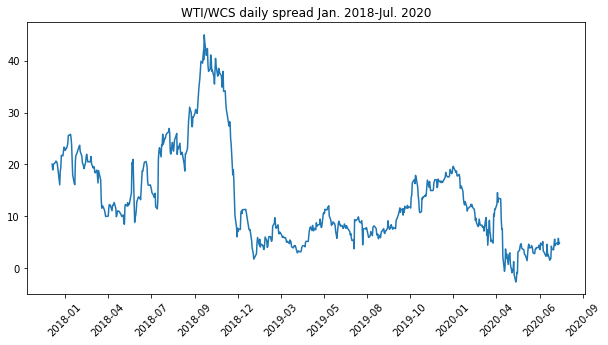

655
optimal solution cost 6.658917525112074 found
optimal trans. cost 4.0 found
congestion surcharge found: [9.40139300074446, 8.276299070008449, 9.227280252181565, 9.427766030215256, 9.723446517451517, 9.985593891527554, 9.773065847882073, 9.721324905779369, 9.018887010822752, 5.403888673042431, 8.083610648700269, 8.70235300650981, 11.098575915694926, 10.992791852099653, 12.026217022806474, 12.671931305720406, 12.547361418432814, 12.029984296831895, 12.544871717049801, 12.87214076606837, 13.466643939999777, 14.940260734029422, 14.911160630588057, 15.152967339098176, 14.451249565127302, 13.177245704536677, 10.522180357458147, 7.354246943046736, 5.654820790404948, 5.439573655143814, 9.984438785298938, 11.118735185236577, 11.239716214171818, 12.494694267354657, 12.8216422888115, 13.035397335818566, 11.842783673105043, 10.930677271249706, 9.719280207203305, 9.404562064519666, 9.073416150367887, 8.532592383268568, 9.710252458029192, 10.765501769630749, 11.294109960185395, 10.6502495058972,

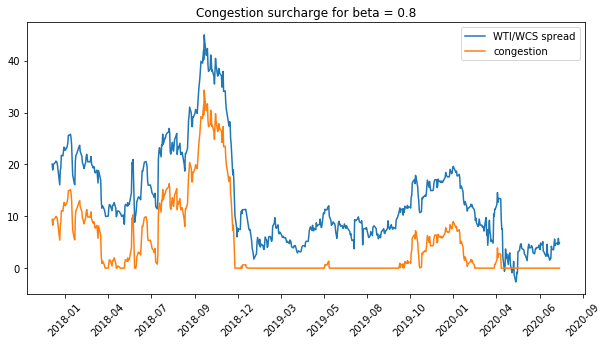

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from matplotlib.dates import DateFormatter

from itertools import product
from sys import stdout as out
from mip import Model, xsum, minimize, BINARY


# Plot Parameters
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['lines.linewidth'] = 1.5


dataframe = pd.read_csv('Data/Cleaned_WTI_WSC.csv')
dataframe['DateTime'] = pd.to_datetime(dataframe['DateTime'], format="%Y-%m-%d")
spread = dataframe['WTI_WCS_diff'] - 5
# 5 is pretty much the spread of heavy and light crude oil at same place
# then the spread now is combination of the transportation cost (pipeline) and the congestion surcharge
print(min(spread),max(spread))
fig, ax = plt.subplots()

x = dataframe['DateTime']
plt.plot(x, spread)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45) 
plt.title('WTI/WCS daily spread Jan. 2018-Jul. 2020')
plt.show()

nodes = ['Hardisty', 'Cushing']
#trans_cost = [6.35]
# transportation cost from Hardisty to Cushing is 5.65-7.05 by Enbridge and 6.35 to 10.46 by Keystone
# choose the midpoint of Enbridge
beta = 0.8   # percentage of the time with congestion
M = 100   # a reasonable upperbound for congestion surcharge
T = len(spread)
print(T)

model = Model()

# define the variables
eps = [model.add_var(lb=-20, ub=20) for t in range(T)]
omega = [model.add_var(lb=0, ub=50) for t in range(T)]
alpha = model.add_var(lb=0, ub=20)
psi = [model.add_var(var_type=BINARY) for t in range(T)]
trans_cost = model.add_var(lb=4)
# objective function
model.objective = minimize(alpha)

#constrains
for t in set(range(T)):
    model += spread[t] -trans_cost - eps[t] - omega[t] ==0, 'price decompose'
    model += eps[t] + alpha >= 0, 'boundary for eps is [-alpha, alpha]'
    model += eps[t] -alpha <=0
    model += eps[t]-alpha + (1-psi[t]) * M >= 0, ''
    model += omega[t]-psi[t]*M <= 0

model += xsum(psi[t] for t in range(T)) <= int(beta*T)

# optimizing
model.optimize()

if model.num_solutions:
    print('optimal solution cost {} found'.format(model.objective_value))
    print('optimal trans. cost {} found'.format(trans_cost.x))
    omega1 = [omega[i].x for i in range(T)]
    print('congestion surcharge found: %s' % omega1)
    
fig, ax = plt.subplots()
plt.plot(x, spread,label='WTI/WCS spread')
plt.plot(x, omega1,label='congestion')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45) 
plt.title('Congestion surcharge for beta = %s' % beta )
plt.legend()
plt.show()

